# Проект: вариант 2
## Задание 1. A/B–тестирование
### Вопросы

#### Предлагаем Вам ответить на следующие вопросы:

1. На какие метрики Вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?

#### Требования к ответу:

1. При выполнении тестового задания необходимо использовать язык программирования Python. 
2. В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
3. Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

#### Импортируем необходимые библиотеки для решения поставленных задач

In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from scipy import stats
from scipy.stats import bootstrap
import requests
from urllib.parse import urlencode
import requests
import json

#### Создаем функцию для считывания данных из яндекс диска

In [61]:
def ydisk(public_key, sep=None):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    if sep: 
        df = pd.read_csv(download_url, sep=';')
    else:
        df = pd.read_csv(download_url)
    return df

#### Выгружаем данные, подготавливаем их для А-В тестирования

In [145]:
active_studs = 'https://disk.yandex.com.am/d/kKJrI0Vo6iGksQ'
df_active_studs = ydisk(active_studs)

In [146]:
df_active_studs.head()
# Изучаем выгруженные данные.
# В данных можно заметить, что есть только столбец student_id.

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [147]:
checks = 'https://disk.yandex.com.am/d/y2mQCHt5V-epjw'
df_checks = ydisk(checks, sep = 1)

In [148]:
df_checks.head()
# Изучяем данные
# В полученном фрейме данных есть два столбца, student_id - информация об id пользователей в дни проведения эксперимента,
# rev - сумма покупки.

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [149]:
groups = 'https://disk.yandex.com.am/d/g3tbayyEaDxzVg'
df_groups = ydisk(groups, sep=1)

In [150]:
df_groups.head()
# Изучаем данные, 
# есть столбец с id пользователя, и столбец grp, в какую группую разделили пользователя

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [151]:
group_add = 'https://disk.yandex.com.am/d/bBOuLgTNIzSoOQ'
df_group_add = ydisk(group_add)

In [152]:
df_group_add.head()
# Изучаем данные,
# Есть столбец с id пользователя, и столбец grp - в какую группу разделили пользователя.

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


Есть основные данные о принадлежности пользователей к основной и тестовой группе - **df_groups**,
Так же есть дополненные данные **df_group_add** - о принадлежности пользователей к определенной группе,
Для полноценного анализа нам необходимо их объеденить в один фрейм данных.
Будем использовать метод **"append"**

In [77]:
df_groupd_all = df_groups.append(df_group_add)
# объединяем два фрейма данных в один - df_groupd_all

In [78]:
df_groupd_all.nunique()
# Проверяем полученный Df на уникальность данных

id     74576
grp        2
dtype: int64

In [79]:
df_groupd_all.isna().sum()
# Проверяем фрейм данных на пропущенные значения.

id     0
grp    0
dtype: int64

In [80]:
df_groupd_all.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [81]:
df_test_matches = df_groupd_all.groupby('grp', as_index=False).agg({'id':'count'})
# Проверяем группы, на колличество пользователей, чтобы оценить эффективность системы сплитования.

In [82]:
df_test_matches['%'] = df_test_matches.id/df_test_matches.id.sum()*100

In [83]:
df_test_matches
# При анализе групп было замеченно, что пользователи поделились неравномерно; 
# Вывод: необходимо проверить систему сплитования и провести тест заново. 
# Действия: продолжаем работать с уже имеющимися данными.

,grp,id,%
0,A,14693,19.702049
1,B,59883,80.297951


In [84]:
# В фрейме данных об активности пользователей в день проведения эксперимента есть только столбец об их id, 
# добавляем еще столбец - метку, где значения в каждой строке для активных пользователей будет 1.

In [85]:
df_active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [86]:
df_active_studs['activ'] = 1

In [87]:
df_active_studs.shape

(8341, 2)

In [88]:
df_checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [89]:
df_checks.shape

(541, 2)

In [90]:
# Проверим все ли Активные пользователи в день эксперимента совершили оплату, 
# для этого объеденим два фрейма данных: df_active_studs и df_checks, и найдем их общие строки.

In [91]:
df_active_studs.merge(df_checks, on = 'student_id').shape

(392, 3)

In [92]:
# При анализе данных, видно, что при merge фреймов данных общих строк 392, 
# следовательно только эти пользователи были активны и совершили оплату. 
# Остальных 541-392 = 149 пользователей не будем учитывать в нашем эксперименте.
# Возможно у них был отложенный платеж, или какой либо сбой в системе оплаты.

В финальном фрейме данных необходима следующая информация:
1. все данные об id активных пользователях, 
2. данные о принадлежности к основной или экспериментальной группе, 
3. данные об оплате.

#### Собирем финальных фрейм данных из уже имеющихся

In [93]:
df_final = df_groupd_all.rename(columns={'id':'student_id'}).merge(df_active_studs, on='student_id').merge(df_checks, how = 'left', on = 'student_id')

In [94]:
df_final.shape

(8341, 4)

In [95]:
df_final.head()

,student_id,grp,activ,rev
0,1627,A,1,990.0
1,2085,B,1,NaN
2,2215,B,1,NaN
3,3391,A,1,NaN
4,3401,B,1,NaN


In [96]:
# Проверим колличество активных пользователей по группам

In [97]:
df_final_matches = df_final.groupby('grp',as_index=False).agg({'student_id':'count'})

In [98]:
df_final_matches['%'] = df_final_matches.student_id/df_final_matches.student_id.sum()*100
df_final_matches.head()
# Процентное соотношение в группах активных пользователей изменилось не существенно
# Действие: продолжаем анализ

,grp,student_id,%
0,A,1538,18.439036
1,B,6803,81.560964


In [99]:
# Проверили что не потеряли данные об активных пользователях, df_final - 8341 строк, df_active_studs - 8341 строк

In [100]:
df_final.isna().sum()

student_id       0
grp              0
activ            0
rev           7949
dtype: int64

In [101]:
8341 - 7949
# 392 строк с оплатой, что соответсвует проверки выше(df_active_studs.merge(df_checks, on = 'student_id').shape - 392 строк общих)

392

In [102]:
df_final.nunique()
# проверяем данные на уникальность

student_id    8341
grp              2
activ            1
rev             38
dtype: int64

Таким образом, проверив финальные данные и убедившись,
что в процессе анализа и формирования финального фрейма ничего не потеряли, 
можно приступать в определению метрик и анализа АВ тестирования.

In [103]:
df_final.head()

,student_id,grp,activ,rev
0,1627,A,1,990.0
1,2085,B,1,NaN
2,2215,B,1,NaN
3,3391,A,1,NaN
4,3401,B,1,NaN


In [104]:
df_final.rev = df_final.rev.fillna(0)

In [105]:
df_final.head()

,student_id,grp,activ,rev
0,1627,A,1,990.0
1,2085,B,1,0.0
2,2215,B,1,0.0
3,3391,A,1,0.0
4,3401,B,1,0.0


In [106]:
df_final['purchase'] = df_final.rev.astype(bool).astype(int)
# Добавим в финальный фрейм данных новую колонку purchase,
# где будет записанна информация о совершенной покупке(1==была покупка.).
# Данный столбец будет необходим для расчета CR.

In [107]:
df_final.nunique()

student_id    8341
grp              2
activ            1
rev             39
purchase         2
dtype: int64

In [108]:
df_final.head()

,student_id,grp,activ,rev,purchase
0,1627,A,1,990.0,1
1,2085,B,1,0.0,0
2,2215,B,1,0.0,0
3,3391,A,1,0.0,0
4,3401,B,1,0.0,0


<b>На какие метрики Вы смотрите в ходе анализа и почему? </b>

При анализе финального датафрейма **df_final** можно виделить следующие метрики:
1. средняя выручка на одного пользователя или по другому **ARPU**
2. средняя выручка на одного платящего пользователя или по другому **ARPPU**
3. конверсия в покупку или по другому **CR**

#### Cобирем таблицу метрик для каждой группы

In [109]:
df_final.head()

,student_id,grp,activ,rev,purchase
0,1627,A,1,990.0,1
1,2085,B,1,0.0,0
2,2215,B,1,0.0,0
3,3391,A,1,0.0,0
4,3401,B,1,0.0,0


In [110]:
df_ARPU = df_final.groupby('grp',as_index=False).agg({'rev':'mean'}).rename(columns={'rev':'ARPU'}).round(2)
df_ARPU.head()

,grp,ARPU
0,A,47.35
1,B,58.06


In [111]:
df_ARPPU = df_final.query('purchase==1').groupby('grp',as_index=False).agg({'rev':'mean'}).rename(columns={'rev':'ARPPU'}).round(2)
df_ARPPU.head()

,grp,ARPPU
0,A,933.59
1,B,1257.88


In [112]:
df_ct = pd.crosstab(df_final.grp, df_final.purchase).reset_index()
df_ct['CR'] = df_ct[1]/(df_ct[1]+df_ct[0])*100
df_ct = df_ct[['grp','CR']]
df_ct.head()

purchase,grp,CR
0,A,5.071521
1,B,4.615611


In [113]:
df_metrics = df_ARPU.merge(df_ARPPU, on='grp').merge(df_ct, on='grp')

In [114]:
df_metrics

,grp,ARPU,ARPPU,CR
0,A,47.35,933.59,5.071521
1,B,58.06,1257.88,4.615611


По таблице df_metrics такие метрики как **ARPU** и **ARPPU** показывают **рост**, при этом метрика **CR** **уменьшается**.
Таким образом, можно сформировать 3 гипотезы, которые в дальнейшем и будем тестировать.
###### Гипотезы:
1. Гипотеза 1 - метрика **ARPU** в тестовой группе увеличилась;
2. Гипотеза 2 - метрика **ARPPU** в тестовой группе увеличилась;
3. Гипотеза 3 - метрика **CR** в тестовой группе уменьшилась.

**Гипотеза 1:** метрика ARPU в тестовой группе увеличилась

In [115]:
df_final.head()

,student_id,grp,activ,rev,purchase
0,1627,A,1,990.0,1
1,2085,B,1,0.0,0
2,2215,B,1,0.0,0
3,3391,A,1,0.0,0
4,3401,B,1,0.0,0


In [116]:
# Построим графики, чтобы посмотреть на нормальность распределения.

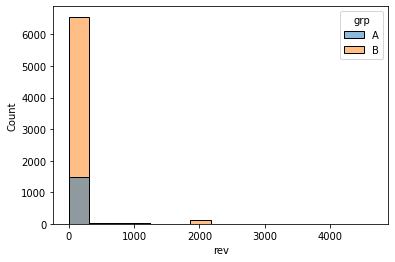

In [117]:
sns.histplot(data = df_final, x='rev', hue='grp')

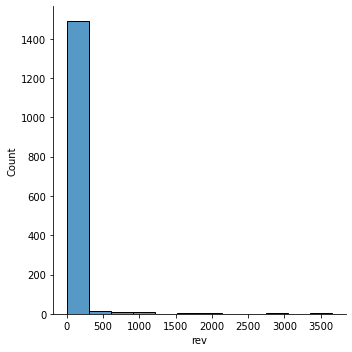

In [118]:
sns.displot(data = df_final[df_final.grp =='A'], x='rev')

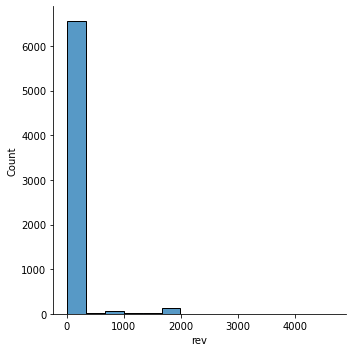

In [119]:
sns.displot(data = df_final[df_final.grp =='B'], x='rev')

По графикам видно, что распределение является **ненормальным**.
Для подтверждения этого проведем дополнительно  Тест **Шапиро-Уилка** на нормальность распределения.

1. **H0** - случайная величина X распределена нормально
2. **H1** - случайная величина X распределена не нормально

In [120]:
stats.shapiro(df_final[df_final.grp =='A'].rev)

ShapiroResult(statistic=0.1541670560836792, pvalue=0.0)

In [121]:
stats.shapiro(df_final[df_final.grp =='B'].rev)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.18124502897262573, pvalue=0.0)

In [122]:
# Так как нулевая гипотеза в случае Шапиро-Уилка — нормальность распределения, 
# то здесь мы можем сделать вывод, что распределение отклоняется от нормального. 

Таким образом, так как анализируемая метрика ARPU является колличественной,то для статистичекого подтверждения его изменений в тестовой группе, можно рассмотреть такие тесты как **t-test, bootstrap, Манна-Уитни**. 
При дальнейшем анализе было выявленно, что распределение данных в группах А и В отличаеться от нормального, поэтому чтобы не допустить ошибок 1 рода при t-teste, будем проводить тест bootstrap чтобы сравнить средние значения выборок.

В этом примере Bootstrap использует следующие нулевую и альтернативную гипотезы:
1. **Н0** - нет различий между средними значениями в тестовой и контрольной группой;
2. **Н1** - есть различия между средними значениями в тестовой и контрольной группой.

In [123]:
def bootstrap_(group_A, group_B, function): #создали функцию, которая принимает данные А-В групп и функцию(среднее, медиана и тд)
    num_samples = 10000 #колличество повторений выборки
    bootstrap_diffs = [] #путой список
    for i in range(num_samples): #цикл
        bootstrap_group_A = group_A.sample(frac = 1, replace=True) #выборка группы А
        bootstrap_group_B = group_B.sample(frac = 1, replace=True) #выборка группы В
        bootstrap_diff = function(bootstrap_group_A) - function(bootstrap_group_B) #Разница средних выборок между группами
        bootstrap_diffs.append(bootstrap_diff) #заполняем пустой список
    q_min = pd.Series(bootstrap_diffs).quantile(0.025) #рассчитываем квантили
    q_max = pd.Series(bootstrap_diffs).quantile(0.975) #рассчитываем квантили
    has_effect = not (q_min < 0 < q_max) #логическое значение, попадает ли 0 в 95% доверительный интервал разниц средних между выборками
    return print("Отличия статистически значимые:", has_effect, "quantile 0.025:" , q_min , "quantile 0.975:", q_max) #вывод результата

In [124]:
group_A = df_final.query('grp=="A"')['rev']
group_B = df_final.query('grp=="B"')['rev']
function = np.mean
# определяем параметры функции

In [125]:
bootstrap_(group_A, group_B, function) 
# вычисляем

Отличия статистически значимые: False quantile 0.025: -26.387384860933476 quantile 0.975: 6.181979106587724


**bootstrap** показывает что стат значимых различий между группами нет, 
следовательно **ARPU** в тестовой и контрольной группе не различаются.

**Гипотеза 2**: метрика ARPPU в тестовой группе увеличилась

Так как анализируемая метрика ARPU является колличественной и рассчитывает средние значения,то для статистичекого подтверждения его изменений в тестовой группе, можно рассмотреть такие тесты как t-test и bootstrap. 

При дальнейшем анализе было выявленно, что распределение данных в группах А и В отличаеться от нормального, поэтому чтобы не допустить ошибок 1 рода при t-teste, будем проводить тест - bootstrap.

Для анализа данной гипотезы, необходимо в финальном фрейме данных оставить только тех ,
кто совершил покупку во время эксперимента.

In [126]:
df_final.head()

,student_id,grp,activ,rev,purchase
0,1627,A,1,990.0,1
1,2085,B,1,0.0,0
2,2215,B,1,0.0,0
3,3391,A,1,0.0,0
4,3401,B,1,0.0,0


In [127]:
df_purchase = df_final.query('purchase ==1')
df_purchase.head()
# оставляем только тех кто сделал покупку

,student_id,grp,activ,rev,purchase
0,1627,A,1,990.0000,1
10,100300,B,1,990.0000,1
12,108270,B,1,290.0000,1
246,264473,B,1,1900.0001,1
279,274352,B,1,690.0000,1


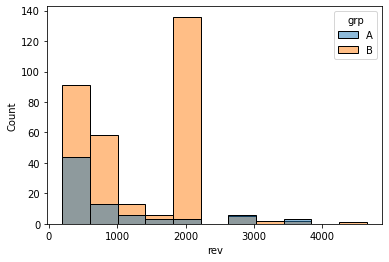

In [128]:
sns.histplot(data = df_purchase, x='rev', hue='grp')

По графику распределение отличнается от нормального.
Статистичеки проверим нормальность распределения.

In [129]:
stats.shapiro(df_purchase[df_purchase.grp =='A'].rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [130]:
stats.shapiro(df_purchase[df_purchase.grp =='B'].rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

Так как нулевая гипотеза в случае **Шапиро-Уилка** — нормальность распределения, 
то в случае p_value<0.05  мы можем сделать вывод, что распределение отклоняется от нормального. 


#### Проведем bootstrap тест

In [131]:
group_A = df_final.query('purchase==1').query('grp=="A"').rev
group_B = df_final.query('purchase==1').query('grp=="B"').rev
function = np.mean

In [132]:
bootstrap_(group_A, group_B, function)

Отличия статистически значимые: True quantile 0.025: -535.1919812569411 quantile 0.975: -92.55864319716657


Bootstrap показывает стат значимые различия, 
следовательно метрика **ARPPU** в тестовой группе **увеличилась стат значимо**.

#### Гипотеза 3 - метрика CR в тестовой группе уменьшилась.

In [133]:
df_final.groupby('grp').size() 
# сколько наблюдений в каждой группе

grp
A    1538
B    6803
dtype: int64

In [134]:
df_final.groupby('grp').student_id.nunique()
# сколько юзеров в каждой группе

grp
A    1538
B    6803
Name: student_id, dtype: int64

In [135]:
pd.crosstab(df_final.grp, df_final.purchase)

purchase,0,1
grp,,
A,1460,78
B,6489,314


Так как метрика **CR** является категориальной, конверсия в покупку активных пользователей во время теста, 
поэтому к данной метрике применим стат тест - **chi2:**
1. Н0 - нет различий между группами
2. Н2 - есть различия между группами

In [136]:
exp, obs, stats = pg.chi2_independence(data = df_final, x = 'grp', y = 'purchase')

In [137]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


Во всех случаях **p-value > 0**,  следовательно принимаем нулевую гипотезу и можем говорить,
что **CR** между тестовой и контрольной группой **статистически не изменился**.

In [138]:
df_metrics

,grp,ARPU,ARPPU,CR
0,A,47.35,933.59,5.071521
1,B,58.06,1257.88,4.615611


<u>Таким образом</u>, в ходе анализа данных полученных при эксперименте, можно выделить следующие выводы:
    1. Баг в системе сплитования - процентное соотношение пользователей в тестовой и контрольной группе значительно различается.
    Рекомендация: наладить систему сплитования, провести дополнительно А-А тест и провести А_В тест заново.
    2. Проанализированны такие метрики как ARPU, ARPPU, CR. 
     В данном А-В тесте статистические различия есть только в метрике ARPPU, 
    метрики ARPU  и  CR статистически не отличаются в тестовой и контрольной группе.
    3. Новая механика оплаты услуг на сайте существенно увеличивает метрику ARPPU на каждого платящего пользователя.
<u>Вывод</u>: провести А-В тест заново, с уже налаженной системой сплитования, 
и если в новом тесте результаты не изменяться, и метрика ARPPU  так же существенно выше в тестовой группе
(платящие пользователи с новой механникой покупают больше, чем контрольная группа) 
то стоит запускать новую механику оплаты на всех пользователей.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

In [139]:
import pandahouse as ph

2.1 Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [140]:
# Задаем параметры подключения
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [141]:
# Создаем запрос
q_1 = '''
    SELECT count(st_id) as diligent_students
    from(
        SELECT 
            extract(month from timest) as month, 
            st_id, 
            sum(correct) as count_peas
        from peas
        GROUP BY 
            st_id, 
            month
        HAVING count_peas > 19
        ORDER BY count_peas DESC
        )
    '''
# отпровляем запрос и результат записываем в пандосовский датафрейм
q_diligent_students = ph.read_clickhouse(query=q_1, connection=connection_default)
# читаем результат
q_diligent_students

,diligent_students
0,136


In [142]:
# diligent_students = 136, количество очень усердных студентов.

### 2.2 Оптимизация воронки

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
1. ARPU 
2. ARPAU 
3. CR в покупку 
4. СR активного пользователя в покупку 
5. CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [144]:
# Создаем запрос
q_2 = '''
    SELECT 
        st.test_grp as groups,
        round(sum(ch.money) / count(ps.st_id), 2) as ARPU,
        round(sum(ch.money) filter(where ps.activ_all=1) / count(ps.st_id) filter(where ps.activ_all=1), 2) as ARPAU,
        round(count(ps.st_id) filter(where ch.money>0) / count(ps.st_id) * 100, 2) as CR,
        round(count(ps.st_id) filter(where ch.money>0 and ps.activ_all =1) / count(ps.st_id) filter(where ps.activ_all =1) * 100, 2) as CR_activ,
        round(count(ps.st_id) filter(where ch.sales_math =1) / count(ps.st_id) filter(where ps.activ_math =1) * 100, 2) as CR_activ_math
    FROM studs as st
    LEFT JOIN 
        (
        SELECT 
            st_id,
            case when sum(correct) > 10 then 1 else 0 end as activ_all,
            case when sum(CASE when subject = 'Math' then 1 else 0 end) FILTER (where correct = 1) > 1 then 1 else 0 end as activ_math
        from peas
        group by st_id
        ) as ps
    ON 
        st.st_id = ps.st_id
    LEFT JOIN 
        (
        SELECT 
            st_id , 
            sum(money) as money, 
            sum(CASE when subject = 'Math' then 1 else 0 end) as sales_math
        FROM final_project_check
        GROUP BY st_id
        ) as ch
    ON   
        st.st_id = ch.st_id
    GROUP BY st.test_grp
    '''
# отпровляем запрос и результат записываем в пандосовский датафрейм
q_metrics = ph.read_clickhouse(query=q_2, connection=connection_default)
# читаем результат
q_metrics

,groups,ARPU,ARPAU,CR,CR_activ,CR_activ_math
0,control,4540.98,10393.70,4.92,11.02,16.33
1,pilot,11508.47,29739.58,10.85,26.04,38.10


# Задание 3. Python
## 3.1 Задача
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [153]:
active_studs = 'https://disk.yandex.com.am/d/kKJrI0Vo6iGksQ'
df_active_studs = ydisk(active_studs)

checks = 'https://disk.yandex.com.am/d/y2mQCHt5V-epjw'
df_checks = ydisk(checks, sep = 1)

groups = 'https://disk.yandex.com.am/d/g3tbayyEaDxzVg'
df_groups = ydisk(groups, sep=1)

group_add = 'https://disk.yandex.com.am/d/bBOuLgTNIzSoOQ'
df_group_add = ydisk(group_add)

In [154]:
def metrics_group(df_active_studs, df_checks, df_groups, df_group_add):
#     закрепляем заголовки
    df_active_studs.columns = ['student_id']
    df_checks.columns =['student_id', 'rev']
    df_groups.columns = ['id', 'grp']
    df_group_add.columns = ['id', 'grp']
#     расчитываем финальный фрейм 
    df_groupd_all = df_groups.append(df_group_add)
    df_active_studs['activ'] = 1
    df_final = df_groupd_all.rename(columns={'id':'student_id'}).merge(df_active_studs, on='student_id').merge(df_checks, how = 'left', on = 'student_id')
    df_final.rev = df_final.rev.fillna(0)
    df_final['purchase'] = df_final.rev.astype(bool).astype(int)
#     вычисляем метрики
    df_ARPU = df_final.groupby('grp',as_index=False).agg({'rev':'mean'}).rename(columns={'rev':'ARPU'}).round(2)
    df_ARPPU = df_final.query('purchase==1').groupby('grp',as_index=False).agg({'rev':'mean'}).rename(columns={'rev':'ARPPU'}).round(2)
    df_ct = pd.crosstab(df_final.grp, df_final.purchase).reset_index()
    df_ct['CR'] = df_ct[1]/(df_ct[1]+df_ct[0])*100
    df_ct = df_ct[['grp','CR']]
#     собираем метрики
    df_metrics = df_ARPU.merge(df_ARPPU, on='grp').merge(df_ct, on='grp')
    return df_metrics

In [155]:
df_metrics = metrics_group(df_active_studs, df_checks, df_groups, df_group_add)
df_metrics

,grp,ARPU,ARPPU,CR
0,A,47.35,933.59,5.071521
1,B,58.06,1257.88,4.615611


## 3.2 Задача
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [156]:
def chart_metrics (df_metrics):
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    sns.barplot(data=df_metrics, x="grp", y="ARPU", ax=axes[0])
    axes[0].set_ylabel('y.e')
    axes[0].set_title("ARPU")
    
    sns.barplot(data=df_metrics, x="grp", y="ARPPU", ax=axes[1])
    axes[1].set_ylabel('y.e')
    axes[1].set_title("ARPPU")
    
    sns.barplot(data=df_metrics, x="grp", y="CR", ax=axes[2])
    axes[2].set_ylabel('%')
    axes[2].set_title("CR")
    
    plt.show()

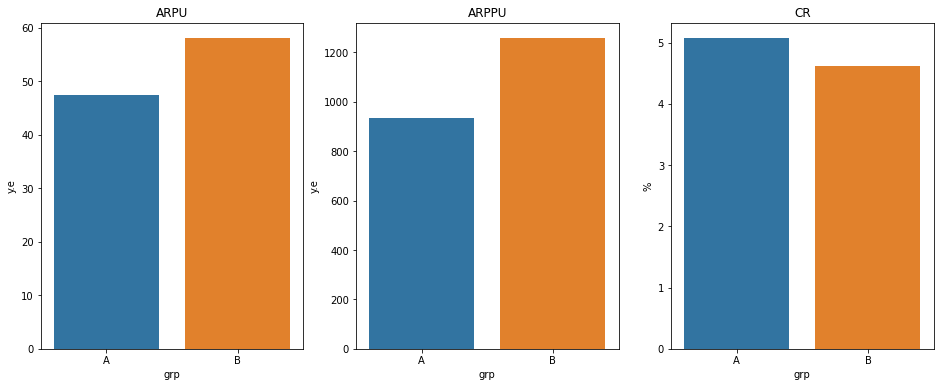

In [157]:
chart_metrics (df_metrics)